# We compute the H^{-1} norm via the Green's function

We need to solve the problem 
$$
-\Delta_x G(x-y) = \delta (y-x) \\
G(x,y) = 0 
$$

Note that if 
$$
-\Delta \varphi_n(x) = \lambda_n \varphi(x)
$$

Then 
$$
G(x,y) = \sum_{i=1}^\infty \frac{1}{\lambda_n}\varphi_n(x)\varphi_n(y)
$$

Consider the 1D Poisson equation with zero boundary condition:
$$
-\Delta u = f \quad \text{in} \quad(0, L) \\
u(x) = 0 \quad \text{for} \quad x = 0, L
$$
We have
$$
-\Delta  \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) =  \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = \lambda_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

And therefore
$$
G(x,y) = \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) \sin\Big(\frac{n\pi y}{L}\Big) 
$$


We aim to compute 
$$
A_{i,j} = \int_{\Omega} \psi_i \Delta^{-1} \psi_j
$$
for $\psi_j$ being measurement function. By the above 
$$
\Delta^{-1} \psi = \int G(x,y)\psi(y)dy =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) \int \sin\Big(\frac{n\pi y}{L}\Big)  \psi(y)dy
$$

Hence 
$$
\Delta^{-1} \psi_i(x) =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n \sin\Big(\frac{n\pi x}{L}\Big)
$$

and 
$$
A_{i,j} = \int_{\Omega} \psi_i(x) \Delta^{-1} \psi_j(x) =   \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n \int \sin\Big(\frac{n\pi x}{L}\Big)\psi_i(x) dx =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n c^j_n
$$

Hence the algorith is 

\begin{aligned}
&\text{Compute }  c^l_n =  \int \sin\Big(\frac{n\pi y}{L}\Big)  \psi_l(y)dy \quad \text{ for each $1\leq l \leq K$ and $1 \leq n \leq  N$} \\
&\text{Build } A_{i,j} =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n c^j_n
\end{aligned}

In [66]:
import jax.numpy as jnp
from jax import random
from jax import scipy 

import numpy as np

import matplotlib.pyplot as plt


from jax.config import config
config.update("jax_enable_x64", True)

from jax import lax

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_24028\2882268066.py:10: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


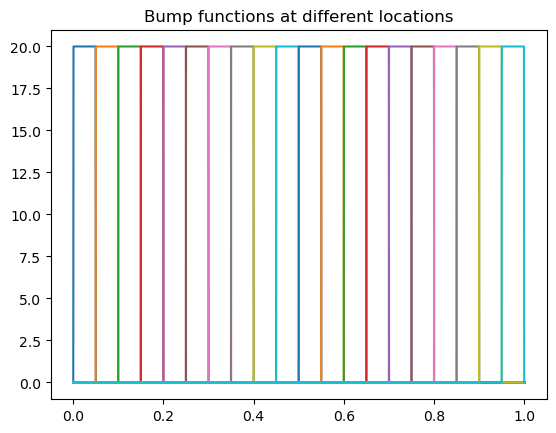

In [3]:
import utils_rough_pde
from utils_rough_pde import *
from utilities_kernel_matern import *

lower, upper = 0.0, 1.0

boundary = jnp.array([[lower, upper]]).T
L =upper -lower 
x = jnp.linspace(0, L, 2000)


L =upper -lower 
x = jnp.linspace(0, L, 2000)
n_order = 10
from scipy.special import roots_legendre
x_q, w_q = roots_legendre(n_order)


# Construct the measurements
n_meas = 20
epsilon_values =  jnp.array([L/(n_meas*2)])
loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]
bump_values = vmap_indicator(x, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(x, bump_values[:, 0, i])
plt.title("Bump functions at different locations")
plt.show()

# Compute the projection onto the basis function

In [4]:
from scipy.special import roots_legendre
n_order = 50
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

In [5]:
vmap_indicator_proj = vmap(indicator, in_axes=(0, None, 0))

In [6]:
bump_proj = vmap_indicator_proj(x_interval, epsilon_values, loc_values)
bump_proj.shape

(20, 50)

In [7]:
def compute_projection_sin(x_q, w_q, f_values, n_coef, L):
    sin_basis = jnp.sqrt(2/L)*jnp.array([jnp.sin(jnp.pi*k/L*x_q) for k in range(1, n_coef+1)])
    return jnp.sum(f_values[None]*sin_basis*w_q, axis = -1)

vmap_compute_projection_sin = vmap(compute_projection_sin, in_axes=(0, 0, 0, None, None))

In [8]:
x_interval.shape, w_interval.shape, bump_proj.shape

((20, 50), (20, 50), (20, 50))

In [9]:
n_coef  = 100
compute_projection_sin(x_interval[0], w_interval[0], bump_proj[0], n_coef, L).shape
proj_indicator = vmap_compute_projection_sin(x_interval, w_interval, bump_proj, n_coef, L)
proj_indicator.shape

(20, 100)

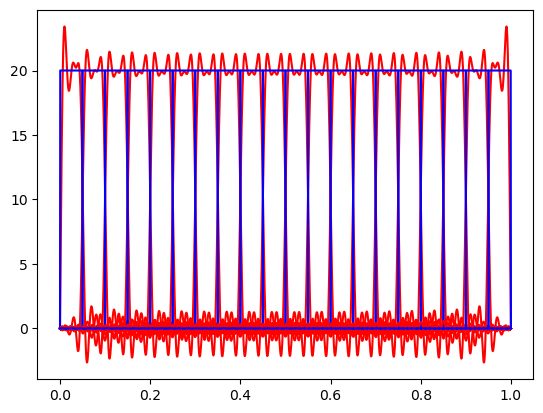

In [10]:
def evaluate_function(x, coef, L):
    values = 0
    for i, c in enumerate(coef):
        values +=c*jnp.sin((i+1)*jnp.pi*x/L)*jnp.sqrt(2/L)
    return values


for i in range(n_meas):
    plt.plot(x, evaluate_function(x, proj_indicator[i], L), color = "red")
    plt.plot(x, bump_values[:, 0, i], color = "blue")
plt.show()

## Create the stiffness matrix

In [11]:
def build_A(c_1, c_2, L):
    n_coef = c_1.shape[0]
    weights = jnp.arange(n_coef) +1
    weights = weights*jnp.pi/L
    weights = weights**(-2)*jnp.sqrt(2/L)
    return jnp.sum(weights*c_1*c_2)

build_A(proj_indicator[0], proj_indicator[1], L)

Array(0.03270573, dtype=float64)

In [12]:
vmap_A = vmap(vmap(build_A, in_axes=(0, None, None)), in_axes=(None, 0, None))

A  = vmap_A(proj_indicator, proj_indicator, L)

A.shape

(20, 20)

# Solving the optimization problem

In the linear case, we aim to solve 
\begin{aligned}
\min_{\alpha}& [ K(-\Delta, \phi) \alpha - f, \psi]A[K(-\Delta, \phi) \alpha - f, \psi] + \lambda \alpha^\intercal \Theta \alpha \\
& K(X_{\partial\Omega}, \phi)\alpha = 0
\end{aligned}

with 
$$
\Theta = \begin{bmatrix}
K(X_{\partial\Omega},X_{\partial\Omega}) &  -\Delta_y K(X_{\partial\Omega}, \boldsymbol{\psi}) \\
-\Delta_y K( X_{\partial\Omega}, \boldsymbol{\psi})^\intercal & \Delta_x\Delta_y K( \boldsymbol{\psi}, \boldsymbol{\psi})
\end{bmatrix}
$$

The above problem then becomes 

\begin{aligned}
\min_{\alpha} \quad &[ K(-\Delta, \phi) \alpha , \psi]A[ K(-\Delta, \phi) \alpha , \psi]  - 2[f, \psi]A[K(-\Delta, \phi) \alpha, \psi] + \lambda \alpha^\intercal \Theta \alpha \\
& K(X_{\partial\Omega}, \phi)\alpha = 0
\end{aligned}

which is rewritten as 
\begin{aligned}
\min_{\alpha} \quad &\alpha^\intercal \Big(K(\phi, \chi) A K(\chi, \phi)  + \lambda  \Theta \Big)\alpha - 2[f, \psi]AK( \chi, \phi)\alpha\\
& K(X_{\partial\Omega}, \phi)\alpha = 0
\end{aligned}

with 
$$
 K(\chi, \phi) = \begin{bmatrix}
-\Delta_y K( X_{\partial\Omega}, \boldsymbol{\psi}) & \Delta_x\Delta_y K( \boldsymbol{\psi}, \boldsymbol{\psi})
\end{bmatrix}
$$

In [13]:
lower, upper = 0.0, 1.0

boundary = jnp.array([[lower, upper]]).T
L =upper -lower 
x = jnp.linspace(0, L, 2000)

In [14]:
# Construct the measurements
n_meas = 200
epsilon_values =  jnp.array([L/(n_meas*2)])
loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]
bump_values = vmap_indicator(x, epsilon_values, loc_values)

In [15]:
# Constuct A 

from scipy.special import roots_legendre
n_order = 50
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)


bump_proj = vmap_indicator_proj(x_interval, epsilon_values, loc_values)
proj_indicator = vmap_compute_projection_sin(x_interval, w_interval, bump_proj, n_coef, L)

A  = vmap_A(proj_indicator, proj_indicator, L)

A.shape

(200, 200)

5.25


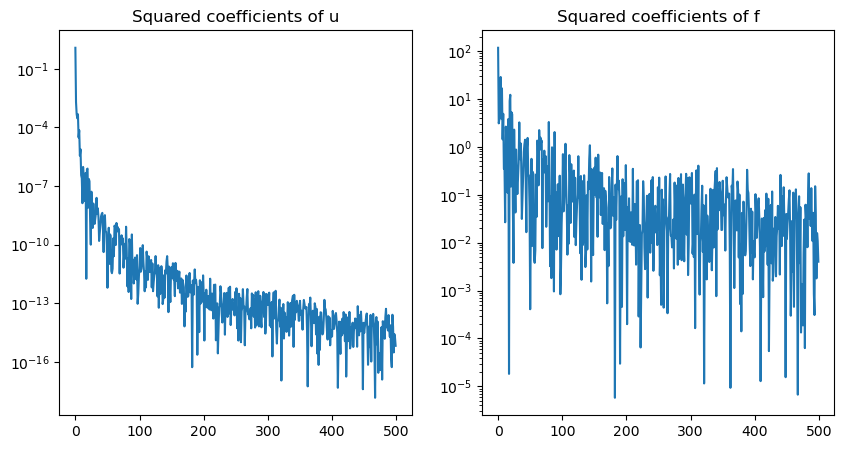

Text(0.5, 1.0, 'Function f')

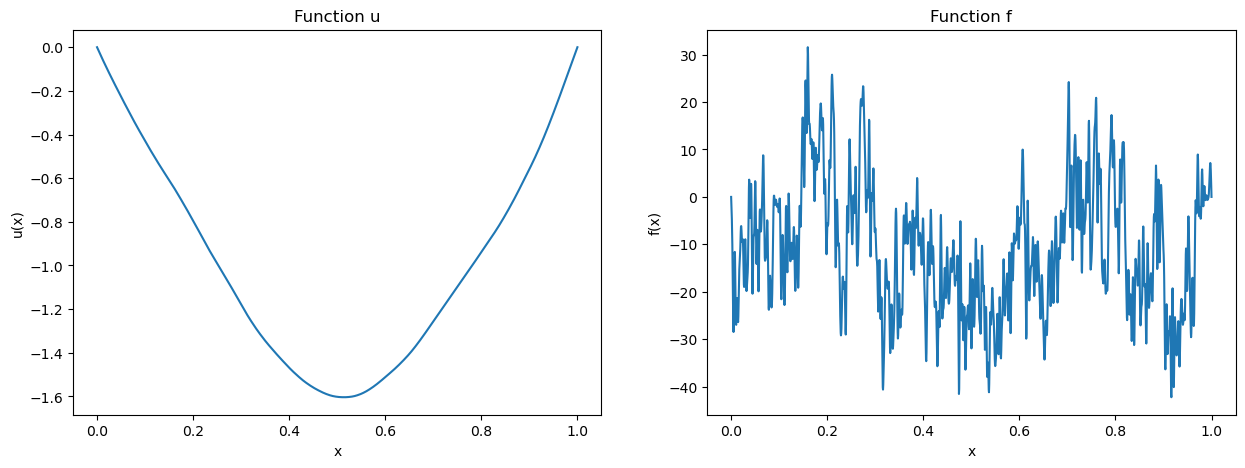

In [16]:
# Create the RHS

# draw random values for the coefficients
key = random.PRNGKey(54)

n_coef = 500

s = 2
alpha = 2*s+1 + 0.25
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f = coef_u*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2

x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f, L=L)

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

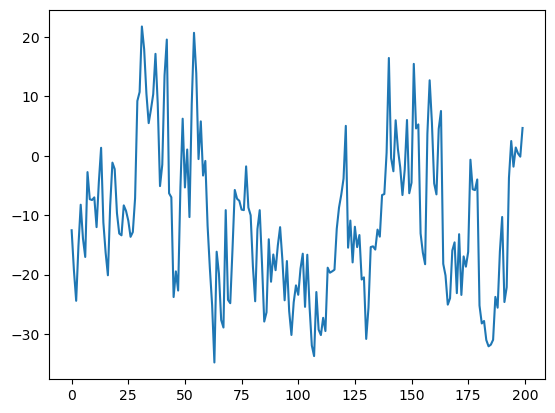

In [17]:
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_psi

# Compute the RHS of the linear system
f_quad = evaluate_function(root_psi, coef_f, L)
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

plt.plot(f_meas)

In [111]:
# Create the matrix components 

length_scale = 1.0

# Compute the kernel matrix
print("Constructing the kernel matrix")
theta_11, theta_12, theta_22 = theta_blocks(boundary,psi_matrix, root_psi, length_scale)


Constructing the kernel matrix


In [112]:
theta_11.shape, theta_12.shape, theta_22.shape

((2, 2), (2, 200), (200, 200))

In [113]:
theta = jnp.block([[theta_11, theta_12], [theta_12.T, theta_22]])
theta.shape

(202, 202)

In [181]:
Q_constraint = jnp.hstack([theta_11, theta_12])
K_interior = jnp.vstack([theta_12, theta_22])
q = -K_interior@A@f_meas
P = K_interior@A@K_interior.T + 1e-8*theta + 1e-10*jnp.eye(theta.shape[0])
eigvals, eigvecs = scipy.linalg.eigh(P)
print(jnp.min(eigvals))

#P = K_interior@A@K_interior.T + 1e-3*jnp.eye(theta.shape[0])

bc = jnp.zeros(shape = (2, ))

Q_constraint.shape, q.shape, P.shape

4.4873988204090963e-10


((2, 202), (202,), (202, 202))

In [182]:
from jaxopt import EqualityConstrainedQP

In [183]:
qp = EqualityConstrainedQP()
sol = qp.run(params_obj=(P, q), params_eq=(Q_constraint, bc))
alpha_opt = sol.params.primal

In [184]:
Q_constraint@alpha_opt,  bc

(Array([-2.13756003, -1.49059208], dtype=float64),
 Array([0., 0.], dtype=float64))

In [185]:
def evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary):
    K_boundary = vmap_kernel(x,boundary, length_scale)
    K_interior = jnp.einsum('nmk,mk->nm',  vmap_laplacian_kernel_quad(x, root_psi[:, :, None], length_scale), psi_matrix)
    K_evaluate = jnp.block([[K_boundary, K_interior]])

    return K_evaluate@c

In [171]:
pred = evaluate_prediction(x, alpha_opt, length_scale, root_psi, psi_matrix, boundary)

In [186]:
pred[0], pred[-1]

(Array(-2.13755998, dtype=float64), Array(-1.49059215, dtype=float64))

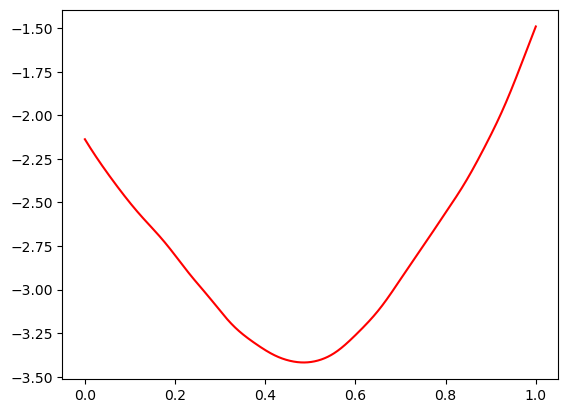

In [173]:
plt.plot(x, pred, color = "red")